In [102]:
%%time

%pip install -U tornado
%pip install "dask[complete]"

import warnings
warnings.filterwarnings("ignore")
import shutil
import os
import pandas as pd
import matplotlib
from sklearn.manifold import TSNE
matplotlib.use(u'nbAgg')
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import codecs
import scipy.sparse
from tqdm import tqdm
import pickle
from sklearn import preprocessing
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd
import random as r
from sklearn.svm import SVC  # Import the Support Vector Machine classifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, chi2, f_regression


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
CPU times: user 195 ms, sys: 60.7 ms, total: 256 ms
Wall time: 6.54 s


In [2]:
# Defining the root directory where your .asm files are stored
root_directory = os.path.expanduser("~/Documents/extracted_files/test")  # Update the path as needed

# Initialize a list to store .asm file paths and their contents
asm_files = []

# os.walk --> Recursively search for .asm files in the subdirectories within subdirectories
for dirpath, dirnames, filenames in os.walk(root_directory):
    for filename in filenames:
        if filename.endswith(".asm"):
            asm_path = os.path.join(dirpath, filename)
            with open(asm_path, 'r', encoding='utf-8', errors='ignore') as file:
                asm_content = file.read()
                asm_files.append((asm_path, asm_content))



In [47]:
def firstprocess():
    #The prefixes tells about the segments that are present in the asm files
    #There are 450 segments(approx) present in all asm files.
    #this prefixes are best segments that gives us best values.
    #https://en.wikipedia.org/wiki/Data_segment
    
    prefixes = ['.text:','.Pav:','.idata:','.data:','.bss:','.rdata:','.edata:','.rsrc:','.tls:','.reloc:','.BSS:','.CODE']
    #this are opcodes that are used to get best results
    #https://en.wikipedia.org/wiki/X86_instruction_listings
    
    opcodes = ['jmp', 'mov', 'retf', 'push', 'pop', 'xor', 'retn', 'nop', 'sub', 'inc', 'dec', 'add','imul', 'xchg', 'or', 'shr', 'cmp', 'call', 'shl', 'ror', 'rol', 'jnb','jz','rtn','lea','movzx']
    #best keywords that are taken from different blogs
    #keywords = ['.dll','std::',':dword']
    #Below taken registers are general purpose registers and special registers
    #All the registers which are taken are best 
    registers=['edx','esi','eax','ebx','ecx','edi','ebp','esp','eip']
    file1=open("asmsmallfile.txt","w+")
#     file1.write("Filename,")    
    # Write headers to the file
    headers = ["Filename"] + prefixes + opcodes + registers
    file1.write(",".join(headers) + "\n")
    files = os.listdir('/home/dikshyant17/Documents/Major/extracted_files/test/sample')
    for f in files:
        #filling the values with zeros into the arrays
        prefixescount=np.zeros(len(prefixes),dtype=int)
        opcodescount=np.zeros(len(opcodes),dtype=int)
#         keywordcount=np.zeros(len(keywords),dtype=int)
        registerscount=np.zeros(len(registers),dtype=int)
        features=[]
        f2=f.split('.')[0]
        file1.write(f2+",")
#         opcodefile.write(f2+" ")
        # https://docs.python.org/3/library/codecs.html#codecs.ignore_errors
        # https://docs.python.org/3/library/codecs.html#codecs.Codec.encode
        with codecs.open('/home/dikshyant17/Documents/Major/extracted_files/test/sample/'+f,encoding='cp1252',errors ='replace') as fli:
            for lines in fli:
                # https://www.tutorialspoint.com/python3/string_rstrip.htm
                line=lines.rstrip().split()
                l=line[0]
                #counting the prefixs in each and every line
                for i in range(len(prefixes)):
                    if prefixes[i] in line[0]:
                        prefixescount[i]+=1
                line=line[1:]
                #counting the opcodes in each and every line
                for i in range(len(opcodes)):
                    if any(opcodes[i]==li for li in line):
                        features.append(opcodes[i])
                        opcodescount[i]+=1
                #counting registers in the line
                for i in range(len(registers)):
                    for li in line:
                        # we will use registers only in 'text' and 'CODE' segments
                        if registers[i] in li and ('text' in l or 'CODE' in l):
                            registerscount[i]+=1
                #counting keywords in the line
#                 for i in range(len(keywords)):
#                     for li in line:
#                         if keywords[i] in li:
#                             keywordcount[i]+=1
        #pushing the values into the file after reading whole file
        for prefix in prefixescount:
            file1.write(str(prefix)+",")
        for opcode in opcodescount:
            file1.write(str(opcode)+",")
        for register in registerscount:
            file1.write(str(register))
#         for key in keywordcount:
#             file1.write(str(key)+",")
        file1.write("\n")
    file1.close()


In [48]:
firstprocess()

IndexError: list index out of range

In [49]:
# asmoutputfile.csv(output genarated from the above two cells) will contain all the extracted features from .asm files
# we will use this file directly
Y=pd.read_csv("/home/dikshyant17/Documents/Major/final.csv")
Y.columns=['ID','Class']
dfasm=pd.read_csv('/home/dikshyant17/Documents/Major/extracted_files/test/sample/vectorized.csv')
result_asm=pd.merge(dfasm,Y,on='ID',how='left')
result_asm

,ID,.text:,.Pav:,.idata:,.data:,.bss:,.rdata:,.edata:,.rsrc:,.tls:,...,edx,esi,eax,ebx,ecx,edi,ebp,esp,eip,Class
0,0a1bb1a2004b1405b80cfcb2249c2cfab85aaed1cad4eb...,342277,0,0,0,0,0,0,102598,0,...,24044,48353,69961,23184,26348,39505,16974,14287,0,SnakeKeylogger
1,0a1ee17e9f99fe5c56130431f0598e30edde7f9b3a384e...,260302,0,0,0,0,0,0,33335,0,...,17226,23919,76989,15366,17494,23133,9991,7697,0,Loki
2,0a4e767ee27b33d4e1dad30ffe016a03a2a8b052391fed...,258450,0,0,0,0,0,0,568,0,...,15347,23053,45821,14567,15659,25730,10613,8865,0,SnakeKeylogger
3,0a5f0b6e561eb8c844d80378b68cf73c686416e98348f6...,197746,0,0,0,0,0,0,601,0,...,11082,17113,28342,11811,12221,16831,10471,7360,0,SnakeKeylogger
4,0a7f9a4a2ff6257feb79223e3432cef859eda0b8e57384...,120575,0,0,0,0,0,0,76938,0,...,10373,16386,37838,12017,12438,17861,8568,6941,0,njrat
5,0cac1630f56f25462bfc12aeeeb52d4eb515783c5cba8f...,36500,0,0,6737,0,5588,0,5281,0,...,2126,4751,10137,2647,4212,4165,3587,1683,0,Smoke Loader
6,0d2b81f717d2a5dbf5e03509eabdd398fd3fb42ce5d46c...,405524,0,0,397702,0,0,0,678,0,...,405260,112779,495429,9812,1983,2931,2017,1373,0,Amadey
7,0d8a2a7eda083b02daf9ee062fbb5c1c57d689916992e4...,17395,0,0,366223,0,358825,0,720,0,...,9327,2263,128932,63102,13192,2464,3341,4927,0,Amadey
8,0e3e6cf4f7fcc5367f2ffa78947973a92b69d8aaca5fda...,35908,0,0,1165,0,0,0,36080,0,...,2657,5949,15969,3774,4855,5469,4243,1959,0,Smoke Loader
9,0f32500a74e76831740141dfc69676b97a72f9f66da30d...,30047,0,0,24213,0,7937,0,7882,0,...,3049,6729,13579,3405,5619,4899,4714,2111,0,Smoke Loader


## ASM FILE SIZES AS A FEATURE

In [50]:
# file sizes as a feature

files=os.listdir('/home/dikshyant17/Documents/Major/extracted_files/test/sample/')
filenames=Y['ID'].tolist()
class_y=Y['Class'].tolist()
class_bytes=[]
sizebytes=[]
fnames=[]
for file in files:
    # print(os.stat('byteFiles/0A32eTdBKayjCWhZqDOQ.txt'))
    # os.stat_result(st_mode=33206, st_ino=1125899906874507, st_dev=3561571700, st_nlink=1, st_uid=0, st_gid=0, 
    # st_size=3680109, st_atime=1519638522, st_mtime=1519638522, st_ctime=1519638522)
    # read more about os.stat: here https://www.tutorialspoint.com/python/os_stat.htm
    statinfo=os.stat('/home/dikshyant17/Documents/Major/extracted_files/test/sample/'+file)
    # split the file name at '.' and take the first part of it i.e the file name
    file=file.split('.')[0]
    if any(file == filename for filename in filenames):
        i=filenames.index(file)
        class_bytes.append(class_y[i])
        # converting into Mb's
        sizebytes.append(statinfo.st_size/(1024.0*1024.0))
        fnames.append(file)
asm_size_byte=pd.DataFrame({'ID':fnames,'size':sizebytes})
asm_size_byte_merged=pd.merge(asm_size_byte,Y,on='ID',how='left')
print (asm_size_byte_merged.head())

                                                  ID       size  \
0  0a5f0b6e561eb8c844d80378b68cf73c686416e98348f6...   7.125170   
1  0f3dc00291dcb787ca5fe22879abdfb5d1113351a79327...  19.245246   
2  0cac1630f56f25462bfc12aeeeb52d4eb515783c5cba8f...   1.756494   
3  0a1bb1a2004b1405b80cfcb2249c2cfab85aaed1cad4eb...  15.835052   
4  0d2b81f717d2a5dbf5e03509eabdd398fd3fb42ce5d46c...  27.140240   

            Class  
0  SnakeKeylogger  
1    Smoke Loader  
2    Smoke Loader  
3  SnakeKeylogger  
4          Amadey  


## Distribution of asm files

<IPython.core.display.Javascript object>


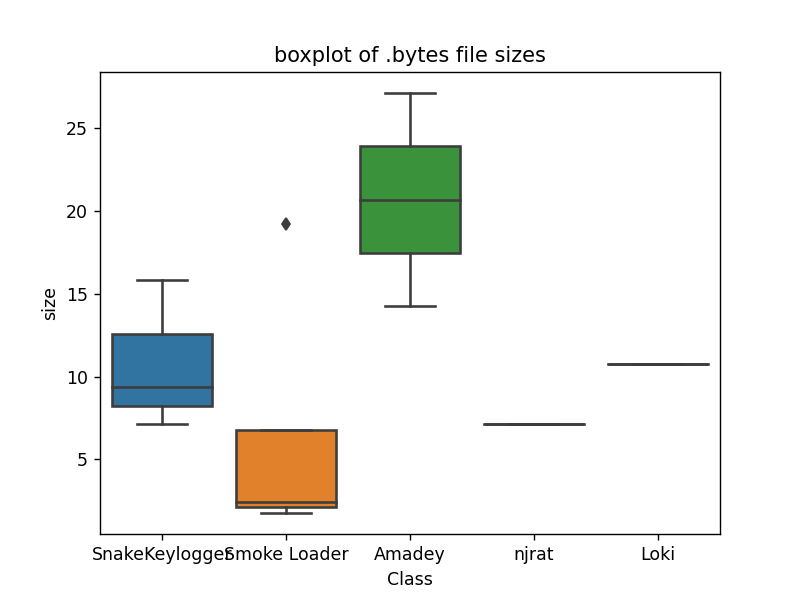

In [51]:
#boxplot of asm files
ax = sns.boxplot(x="Class", y="size", data=asm_size_byte_merged)
plt.title("boxplot of .bytes file sizes")
plt.show()

In [52]:
# add the file size feature to previous extracted features
print(result_asm.shape)
print(asm_size_byte_merged.shape)
result_asm = pd.merge(result_asm, asm_size_byte_merged.drop(['Class'], axis=1),on='ID', how='left')
result_asm

(11, 49)
(11, 3)


,ID,.text:,.Pav:,.idata:,.data:,.bss:,.rdata:,.edata:,.rsrc:,.tls:,...,esi,eax,ebx,ecx,edi,ebp,esp,eip,Class,size
0,0a1bb1a2004b1405b80cfcb2249c2cfab85aaed1cad4eb...,342277,0,0,0,0,0,0,102598,0,...,48353,69961,23184,26348,39505,16974,14287,0,SnakeKeylogger,15.835052
1,0a1ee17e9f99fe5c56130431f0598e30edde7f9b3a384e...,260302,0,0,0,0,0,0,33335,0,...,23919,76989,15366,17494,23133,9991,7697,0,Loki,10.768058
2,0a4e767ee27b33d4e1dad30ffe016a03a2a8b052391fed...,258450,0,0,0,0,0,0,568,0,...,23053,45821,14567,15659,25730,10613,8865,0,SnakeKeylogger,9.362388
3,0a5f0b6e561eb8c844d80378b68cf73c686416e98348f6...,197746,0,0,0,0,0,0,601,0,...,17113,28342,11811,12221,16831,10471,7360,0,SnakeKeylogger,7.125170
4,0a7f9a4a2ff6257feb79223e3432cef859eda0b8e57384...,120575,0,0,0,0,0,0,76938,0,...,16386,37838,12017,12438,17861,8568,6941,0,njrat,7.117259
5,0cac1630f56f25462bfc12aeeeb52d4eb515783c5cba8f...,36500,0,0,6737,0,5588,0,5281,0,...,4751,10137,2647,4212,4165,3587,1683,0,Smoke Loader,1.756494
6,0d2b81f717d2a5dbf5e03509eabdd398fd3fb42ce5d46c...,405524,0,0,397702,0,0,0,678,0,...,112779,495429,9812,1983,2931,2017,1373,0,Amadey,27.140240
7,0d8a2a7eda083b02daf9ee062fbb5c1c57d689916992e4...,17395,0,0,366223,0,358825,0,720,0,...,2263,128932,63102,13192,2464,3341,4927,0,Amadey,14.256224
8,0e3e6cf4f7fcc5367f2ffa78947973a92b69d8aaca5fda...,35908,0,0,1165,0,0,0,36080,0,...,5949,15969,3774,4855,5469,4243,1959,0,Smoke Loader,2.615309
9,0f32500a74e76831740141dfc69676b97a72f9f66da30d...,30047,0,0,24213,0,7937,0,7882,0,...,6729,13579,3405,5619,4899,4714,2111,0,Smoke Loader,2.266025


In [53]:
def normalize(df):
    result1 = df.copy()
    for feature_name in df.columns:
        if (str(feature_name) != str('ID') and str(feature_name)!=str('Class')):
            max_value = df[feature_name].max()
            min_value = df[feature_name].min()
            result1[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return result1

In [54]:
# we normalize the data each column 
result_asm = normalize(result_asm)
result_asm

,ID,.text:,.Pav:,.idata:,.data:,.bss:,.rdata:,.edata:,.rsrc:,.tls:,...,esi,eax,ebx,ecx,edi,ebp,esp,eip,Class,size
0,0a1bb1a2004b1405b80cfcb2249c2cfab85aaed1cad4eb...,0.657623,NaN,NaN,0.000000,NaN,0.000000,NaN,1.000000,NaN,...,0.417044,0.123274,0.339707,0.356923,1.000000,0.227975,1.000000,NaN,SnakeKeylogger,0.554629
1,0a1ee17e9f99fe5c56130431f0598e30edde7f9b3a384e...,0.491690,NaN,NaN,0.000000,NaN,0.000000,NaN,0.321151,NaN,...,0.195954,0.137756,0.210388,0.227221,0.558003,0.121540,0.489701,NaN,Loki,0.355013
2,0a4e767ee27b33d4e1dad30ffe016a03a2a8b052391fed...,0.487941,NaN,NaN,0.000000,NaN,0.000000,NaN,0.000000,NaN,...,0.188118,0.073531,0.197171,0.200340,0.628115,0.131021,0.580146,NaN,SnakeKeylogger,0.299636
3,0a5f0b6e561eb8c844d80378b68cf73c686416e98348f6...,0.365065,NaN,NaN,0.000000,NaN,0.000000,NaN,0.000323,NaN,...,0.134370,0.037513,0.151584,0.149977,0.387867,0.128856,0.463605,NaN,SnakeKeylogger,0.211501
4,0a7f9a4a2ff6257feb79223e3432cef859eda0b8e57384...,0.208856,NaN,NaN,0.000000,NaN,0.000000,NaN,0.748505,NaN,...,0.127791,0.057081,0.154991,0.153155,0.415675,0.099851,0.431160,NaN,njrat,0.211189
5,0cac1630f56f25462bfc12aeeeb52d4eb515783c5cba8f...,0.038672,NaN,NaN,0.016940,NaN,0.015573,NaN,0.046192,NaN,...,0.022513,0.000000,0.000000,0.032653,0.045922,0.023930,0.024005,NaN,Smoke Loader,0.000000
6,0d2b81f717d2a5dbf5e03509eabdd398fd3fb42ce5d46c...,0.785646,NaN,NaN,1.000000,NaN,0.000000,NaN,0.001078,NaN,...,1.000000,1.000000,0.118518,0.000000,0.012608,0.000000,0.000000,NaN,Amadey,1.000000
7,0d8a2a7eda083b02daf9ee062fbb5c1c57d689916992e4...,0.000000,NaN,NaN,0.920848,NaN,1.000000,NaN,0.001490,NaN,...,0.000000,0.244791,1.000000,0.164201,0.000000,0.020180,0.275205,NaN,Amadey,0.492430
8,0e3e6cf4f7fcc5367f2ffa78947973a92b69d8aaca5fda...,0.037474,NaN,NaN,0.002929,NaN,0.000000,NaN,0.348054,NaN,...,0.033353,0.012018,0.018642,0.042072,0.081126,0.033929,0.045377,NaN,Smoke Loader,0.033833
9,0f32500a74e76831740141dfc69676b97a72f9f66da30d...,0.025610,NaN,NaN,0.060882,NaN,0.022119,NaN,0.071685,NaN,...,0.040410,0.007093,0.012538,0.053264,0.065738,0.041108,0.057147,NaN,Smoke Loader,0.020073


## UNIVARIATE ANALYSIS ONLY ON .asm FILES

<IPython.core.display.Javascript object>


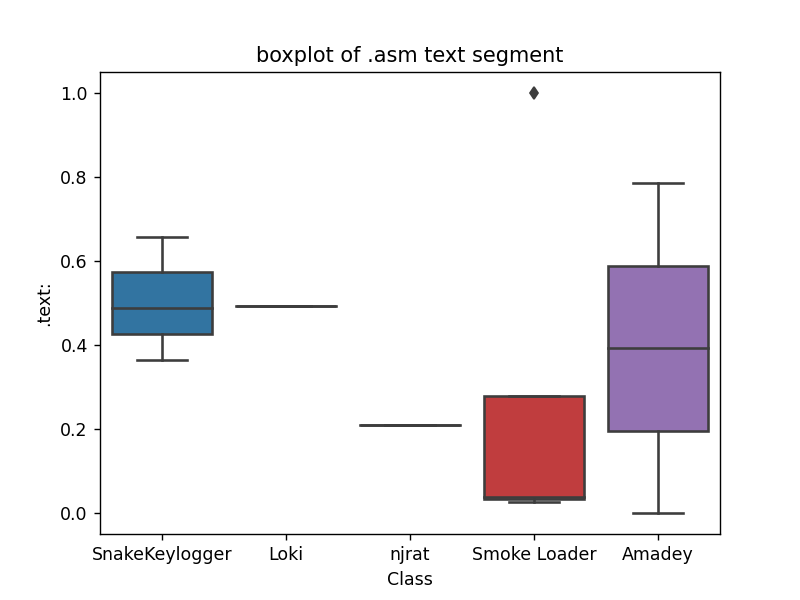

In [55]:
ax = sns.boxplot(x="Class", y=".text:", data=result_asm)
plt.title("boxplot of .asm text segment")
plt.show()

<IPython.core.display.Javascript object>


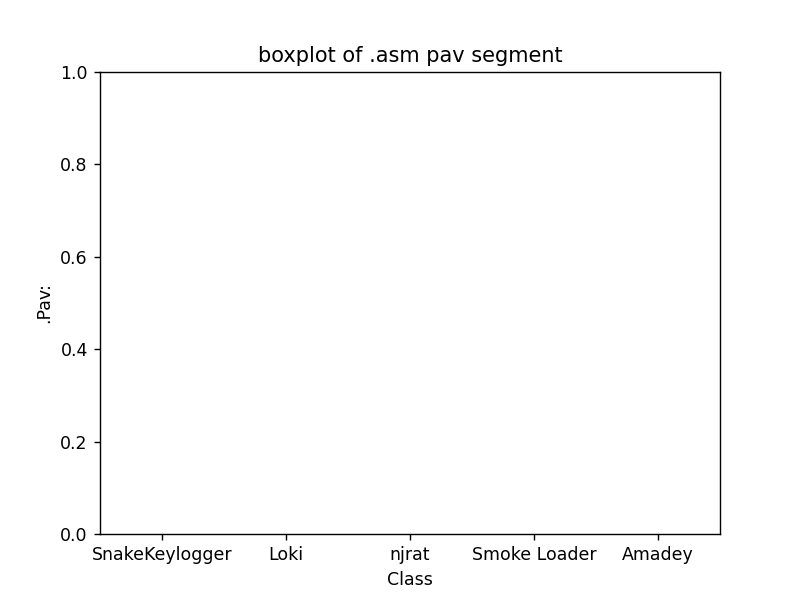

In [56]:
ax = sns.boxplot(x="Class", y=".Pav:", data=result_asm)
plt.title("boxplot of .asm pav segment")
plt.show()

<IPython.core.display.Javascript object>


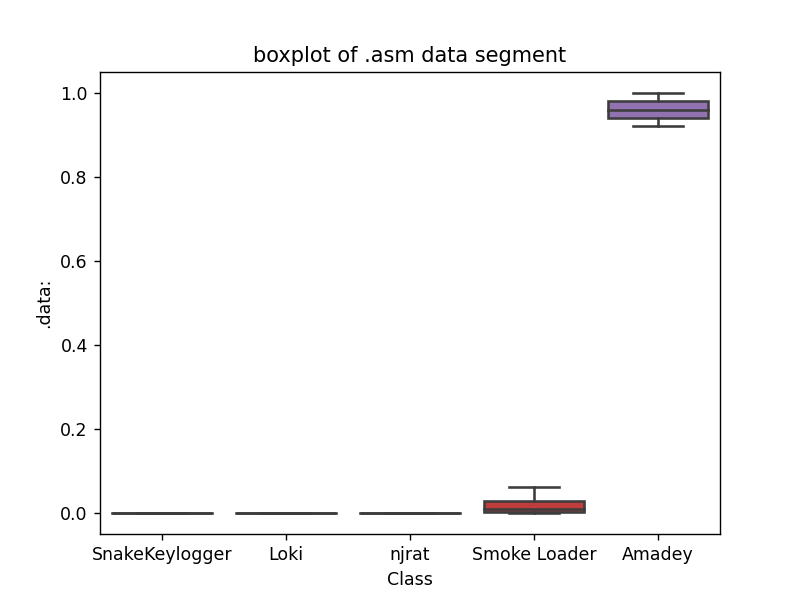

In [57]:
ax = sns.boxplot(x="Class", y=".data:", data=result_asm)
plt.title("boxplot of .asm data segment")
plt.show()

## Multivariate Analysis ONLY on .asm file features

<IPython.core.display.Javascript object>


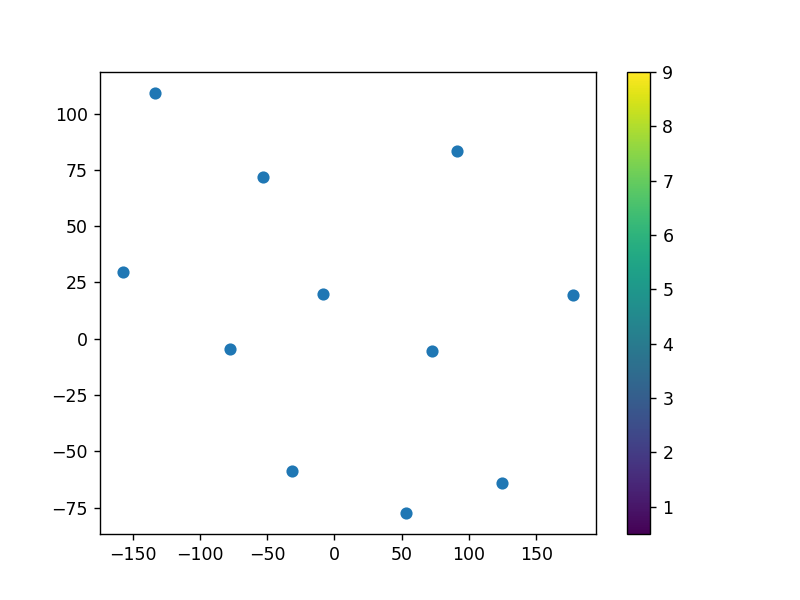

In [65]:
#multivariate analysis on asm files
#this is with perplexity 
xtsne=TSNE(perplexity=8)
data_y=result_asm['Class']
results=xtsne.fit_transform(result_asm.drop(['ID','Class'], axis=1).fillna(0))

vis_x = results[:, 0]
vis_y = results[:, 1]
plt.scatter(vis_x, vis_y, cmap=plt.cm.get_cmap("jet", 9))
plt.colorbar(ticks=range(10))
plt.clim(0.5, 9)
plt.show()

## Extracting Opcodes Bigrams from ASM Files

In [75]:
def calculate_bigram(bigram_tokens):
    sentence=""
    vocabulary_list_for_byte_bigrams=[]
    for i in tqdm(range(len(bigram_tokens))):
        for j in range(len(bigram_tokens)):
            bigram=bigram_tokens[i]+" "+bigram_tokens[j]
            sentence=sentence+bigram+","
            vocabulary_list_for_byte_bigrams.append(bigram)
    return vocabulary_list_for_byte_bigrams

In [106]:
%%time

opcodes_for_bigram = ['jmp', 'mov', 'retf', 'push', 'pop', 'xor', 'retn', 'nop', 'sub', 'inc', 'dec', 'add','imul', 'xchg', 'or', 'shr', 'cmp', 'call', 'shl', 'ror', 'rol', 'jnb','jz','rtn','lea','movzx']
root_path='/home/dikshyant17/Documents/Major/extracted_files/test/'

# Converting list to dictionary for faster runtime
dict_asm_opcodes = dict(zip(opcodes_for_bigram, [1 for i in range(len(opcodes_for_bigram))]))

if not os.path.isdir( root_path + "opcodes_asm_files"):
    os.mkdir(root_path +'opcodes_asm_files')

'''

Noting first that the asm files contains :

1. Address
2. Segments
3. Opcodes
4. Registers
5. function calls
6. APIs

Calculating opcode sequences for each asm file and save in form of a text file, so that we can process the ASM files as text files

In that text file, each row corresponds to respective file. 

Noting, in asm files the opcodes_for_bigram were not placed side by side, instead there are few words between two opcodes. i.e. The Opcodes occurs with an interval.

So during extraction of opcodes_for_bigram we need to preserve the sequence information. 

e.g. which opcode prcede another opcode or which opcode is followed is followed by another opcode.

Based on this, a bigram data-matrix of vectors is to be derived containing the bigram sequence info on each file.

'''
def calculate_sequence_of_opcodes():
    asm_file_names=os.listdir(root_path + 'sample/')
    for this_asm_file in tqdm(asm_file_names):
        each_asm_opcode_file = open(root_path + "opcodes_asm_files/{}_opcode_asm_bi_grams.txt".format(this_asm_file.split('.')[0]), "w+")
        sequence_of_opcodes = ""
        with codecs.open(root_path + 'sample/' + this_asm_file, encoding='cp1252', errors ='replace') as asm_file:
            for lines in asm_file:
                
                line = lines.rstrip().split()            
                
                for word in line:
                    if dict_asm_opcodes.get(word)==1:
                        sequence_of_opcodes += word + ' '
        each_asm_opcode_file.write(sequence_of_opcodes + "\n")
        each_asm_opcode_file.close()
    
calculate_sequence_of_opcodes()

opcodes_asm__bigram_vocabulary = calculate_bigram(opcodes_for_bigram)

100%|████████████████████████████████████████| 26/26 [00:00<00:00, 30762.17it/s]

CPU times: user 14.8 s, sys: 122 ms, total: 14.9 s
Wall time: 15 s


In [107]:
opcodes_asm__bigram_vocabulary

['jmp jmp',
 'jmp mov',
 'jmp retf',
 'jmp push',
 'jmp pop',
 'jmp xor',
 'jmp retn',
 'jmp nop',
 'jmp sub',
 'jmp inc',
 'jmp dec',
 'jmp add',
 'jmp imul',
 'jmp xchg',
 'jmp or',
 'jmp shr',
 'jmp cmp',
 'jmp call',
 'jmp shl',
 'jmp ror',
 'jmp rol',
 'jmp jnb',
 'jmp jz',
 'jmp rtn',
 'jmp lea',
 'jmp movzx',
 'mov jmp',
 'mov mov',
 'mov retf',
 'mov push',
 'mov pop',
 'mov xor',
 'mov retn',
 'mov nop',
 'mov sub',
 'mov inc',
 'mov dec',
 'mov add',
 'mov imul',
 'mov xchg',
 'mov or',
 'mov shr',
 'mov cmp',
 'mov call',
 'mov shl',
 'mov ror',
 'mov rol',
 'mov jnb',
 'mov jz',
 'mov rtn',
 'mov lea',
 'mov movzx',
 'retf jmp',
 'retf mov',
 'retf retf',
 'retf push',
 'retf pop',
 'retf xor',
 'retf retn',
 'retf nop',
 'retf sub',
 'retf inc',
 'retf dec',
 'retf add',
 'retf imul',
 'retf xchg',
 'retf or',
 'retf shr',
 'retf cmp',
 'retf call',
 'retf shl',
 'retf ror',
 'retf rol',
 'retf jnb',
 'retf jz',
 'retf rtn',
 'retf lea',
 'retf movzx',
 'push jmp',
 'push 

# Calcualte opcodes bigram with above defined function and make them a feature and then save the data matrix of feature as a .csv file 

In [109]:
vectorizer_opcode = CountVectorizer(
    tokenizer=lambda x: x.split(),
    lowercase=False,
    ngram_range=(2, 2),
    vocabulary=opcodes_asm__bigram_vocabulary,
)  # Noting, without "tokenizer=lambda x: x.split()", "??" would not get vectorized correctly

file_list_opcode = os.listdir(root_path + "opcodes_asm_files")

opcode_features = vectorizer_opcode.get_feature_names_out()
opcode_features=np.insert(opcode_features,0,'ID')

opcodes_asm_bigram_df = pd.DataFrame(columns=opcode_features)

with open(
    root_path + "featurization/opcodes_asm_bigram_df.csv", mode="w"
) as opcodes_asm_bigram_df:

    opcodes_asm_bigram_df.write(",".join(map(str, opcode_features)))

    opcodes_asm_bigram_df.write("\n")

    for _, this_asm_file in tqdm(enumerate(file_list_opcode)):

        this_file_id = this_asm_file.split("_")[0]  # ID of each this_asm_file

        this_asm_file = open(root_path + "opcodes_asm_files/" + this_asm_file)

        corpus_opcodes_from_this_asm_file = [
            this_asm_file.read().replace("\n", " ").lower()
        ]  # Variable to hold all opcodes for a given this_asm_file

        bigrams_opcodes_asm = vectorizer_opcode.transform(
            corpus_opcodes_from_this_asm_file
        )  # Returning a sparse vector holding all bigram counts from corpus_opcodes_from_this_asm_file

        # Update each row of the dataframe with the bigram counts of the respective this_asm_file
        # And return a dense ndarray representation of this matrix. Because,
        # CountVectorizer produces a sparse representation of the counts using scipy.sparse.csr_matrix
        row = scipy.sparse.csr_matrix(bigrams_opcodes_asm).toarray()

        opcodes_asm_bigram_df.write(
            ",".join(map(str, [this_file_id] + list(row[0])))
        )  # Write a single row in the CSV this_asm_file

        opcodes_asm_bigram_df.write("\n")

        this_asm_file.close()


opcodes_asm_bigram_df = pd.read_csv(
    root_path + "featurization/opcodes_asm_bigram_df.csv"
)

opcodes_asm_bigram_df

11it [00:01,  7.76it/s]


,ID,jmp jmp,jmp mov,jmp retf,jmp push,jmp pop,jmp xor,jmp retn,jmp nop,jmp sub,...,movzx cmp,movzx call,movzx shl,movzx ror,movzx rol,movzx jnb,movzx jz,movzx rtn,movzx lea,movzx movzx
0,0a7f9a4a2ff6257feb79223e3432cef859eda0b8e57384...,497,662,140,359,342,84,0,11,127,...,0,1,0,0,0,0,0,0,0,0
1,0a5f0b6e561eb8c844d80378b68cf73c686416e98348f6...,33,327,34,231,114,75,0,12,400,...,0,0,0,0,1,0,0,0,0,0
2,0a4e767ee27b33d4e1dad30ffe016a03a2a8b052391fed...,41,515,32,248,241,121,0,16,125,...,0,0,0,0,0,0,0,0,0,0
3,0d8a2a7eda083b02daf9ee062fbb5c1c57d689916992e4...,8917,78,3,11484,26,15,0,5,8,...,0,0,0,0,0,0,0,0,1,0
4,0f32500a74e76831740141dfc69676b97a72f9f66da30d...,83,405,5,146,31,103,0,13,15,...,11,1,1,0,0,0,0,0,7,174
5,0a1ee17e9f99fe5c56130431f0598e30edde7f9b3a384e...,47,331,26,213,196,135,0,17,188,...,0,0,0,0,0,0,0,0,0,0
6,0d2b81f717d2a5dbf5e03509eabdd398fd3fb42ce5d46c...,18,62,1,29,14,11,0,1,14,...,0,0,0,0,0,0,0,0,0,0
7,0f3dc00291dcb787ca5fe22879abdfb5d1113351a79327...,115,573,40,611,327,179,0,26,165,...,0,0,0,0,0,0,0,0,0,0
8,0cac1630f56f25462bfc12aeeeb52d4eb515783c5cba8f...,19,269,3,111,25,58,0,14,18,...,3,0,0,0,0,0,0,0,0,5
9,0a1bb1a2004b1405b80cfcb2249c2cfab85aaed1cad4eb...,14616,1114,107,826,396,219,0,27,337,...,1,0,0,0,0,0,0,0,0,0


# ASM File - Top Important 500 features from Opcodes Bigrams 

In [110]:
X_opcode_asm_bigram = opcodes_asm_bigram_df
y = data_y
# X_opcode_asm_bigram.head()

#Get the best 500 features using SelectKBest. 


kbest_object = SelectKBest(score_func=chi2, k=500)

top_features=kbest_object.fit(X_opcode_asm_bigram.drop("ID", axis=1), y)

# Save a dataframe with the feature scores along with the feature names.
# And we will get the best fetures from this dataframe use to 
top_features_scores=pd.DataFrame(top_features.scores_)

# Now to get the original features names i.e. the names of all the columns we will need
# `X_opcode_asm_bigram.columns`
X_opcode_columns=pd.DataFrame(X_opcode_asm_bigram.columns)

# Now concat all  original features names as a column with another column
# which is "top_features_scores"
top_asm_opcode_bigram_df=pd.concat([X_opcode_columns, top_features_scores],axis=1)

# Give 2 Names for these 2 columns of data for this newly creaetd dataframe
top_asm_opcode_bigram_df.columns=["ASM_Opcode_Bigram_Top_Feature_Name","ASM_Opcode_Bigram_Top_Feature_Score"]

# Extract the largest 500 from this dataframw based on the values of "top_features_scores"
top_asm_opcode_bigram_df=top_asm_opcode_bigram_df.nlargest(500,"ASM_Opcode_Bigram_Top_Feature_Score")

top_asm_opcode_bigram_df.head()

,ASM_Opcode_Bigram_Top_Feature_Name,ASM_Opcode_Bigram_Top_Feature_Score
351,xchg imul,1.786381e+06
297,add dec,3.887745e+05
91,push imul,2.228294e+05
341,xchg retf,2.080482e+05
81,push retf,1.457595e+05


In [112]:
top_500_asm_bigram_features=list(top_asm_opcode_bigram_df["ASM_Opcode_Bigram_Top_Feature_Name"])

top_500_asm_bigram_df=pd.concat([X_opcode_asm_bigram["ID"], X_opcode_asm_bigram[top_500_asm_bigram_features]], axis=1)

# The "ID" column was being duplicated, hence need to remove that, and also the possibility of any other duplicated column
top_500_asm_bigram_df = top_500_asm_bigram_df.loc[:,~top_500_asm_bigram_df.columns.duplicated()]

top_500_asm_bigram_df.to_csv(root_path + "featurization/featurization_final/top_500_asm_opcodes_bigram_df.csv",index=None)

top_500_asm_bigram_df.head()


,ID,xchg imul,add dec,push imul,xchg retf,push retf,inc cmp,call sub,inc sub,call cmp,...,pop xor,pop rol,pop jnb,pop jz,xor xor,xor rol,xor jnb,xor jz,xor movzx,retn jmp
0,0a7f9a4a2ff6257feb79223e3432cef859eda0b8e57384...,78,527,209,319,131,220,111,434,102,...,354,56,0,0,256,16,0,0,0,0
1,0a5f0b6e561eb8c844d80378b68cf73c686416e98348f6...,62,443,397,77,110,317,63,205,41,...,662,72,0,0,298,29,0,0,0,0
2,0a4e767ee27b33d4e1dad30ffe016a03a2a8b052391fed...,122,1142,413,110,168,346,89,397,109,...,445,45,0,0,392,23,0,0,0,0
3,0d8a2a7eda083b02daf9ee062fbb5c1c57d689916992e4...,5,546,89,0,9,16,4,37,6,...,27,1,0,0,52,2,0,0,0,0
4,0f32500a74e76831740141dfc69676b97a72f9f66da30d...,7,164,56,7,21,108,9,28,96,...,86,6,0,0,64,4,0,0,6,0


# Opcodes Trigram of ASM Files ---> Featurization

In [114]:
top_500_asm_bigram_features=list(top_asm_opcode_bigram_df["ASM_Opcode_Bigram_Top_Feature_Name"])

top_500_asm_bigram_df=pd.concat([X_opcode_asm_bigram["ID"], X_opcode_asm_bigram[top_500_asm_bigram_features]], axis=1)

# The "ID" column was being duplicated, hence need to remove that, and also the possibility of any other duplicated column
top_500_asm_bigram_df = top_500_asm_bigram_df.loc[:,~top_500_asm_bigram_df.columns.duplicated()]

top_500_asm_bigram_df.to_csv(root_path + "featurization/featurization_final/top_500_asm_opcodes_bigram_df.csv",index=None)

top_500_asm_bigram_df.head()

,ID,xchg imul,add dec,push imul,xchg retf,push retf,inc cmp,call sub,inc sub,call cmp,...,pop xor,pop rol,pop jnb,pop jz,xor xor,xor rol,xor jnb,xor jz,xor movzx,retn jmp
0,0a7f9a4a2ff6257feb79223e3432cef859eda0b8e57384...,78,527,209,319,131,220,111,434,102,...,354,56,0,0,256,16,0,0,0,0
1,0a5f0b6e561eb8c844d80378b68cf73c686416e98348f6...,62,443,397,77,110,317,63,205,41,...,662,72,0,0,298,29,0,0,0,0
2,0a4e767ee27b33d4e1dad30ffe016a03a2a8b052391fed...,122,1142,413,110,168,346,89,397,109,...,445,45,0,0,392,23,0,0,0,0
3,0d8a2a7eda083b02daf9ee062fbb5c1c57d689916992e4...,5,546,89,0,9,16,4,37,6,...,27,1,0,0,52,2,0,0,0,0
4,0f32500a74e76831740141dfc69676b97a72f9f66da30d...,7,164,56,7,21,108,9,28,96,...,86,6,0,0,64,4,0,0,6,0


In [116]:
# Function to return all possible n*n*n combinations of trigrams
def calculate_trigram(tokens):
    sent = ""
    trigram_result = []
    for i in range(len(tokens)):
        for j in range(len(tokens)):
            for k in range(len(tokens)):
                trigram = tokens[i] + " " + tokens[j] + " " + tokens[k]
                trigram_result.append(trigram)
    return trigram_result
  

# test_tokens=['edx','esi','eax']
# trigram_result = calculate_trigram(test_tokens)
# trigram_result

In [119]:
opcodes_trigram = ['jmp', 'mov', 'retf', 'push', 'pop', 'xor', 'retn', 'nop', 'sub', 'inc', 'dec', 'add','imul', 'xchg', 'or', 'shr', 'cmp', 'call', 'shl', 'ror', 'rol', 'jnb','jz','rtn','lea','movzx']

opcodes_trigram_asm_vocabulary = calculate_trigram(
    opcodes_trigram
)  # Holding all n*n*n possible combinations of trigrams_from_asm_files

vectorizer = CountVectorizer(
    tokenizer=lambda x: x.split(),
    lowercase=False,
    ngram_range=(3, 3),
    vocabulary=opcodes_trigram_asm_vocabulary,
)  # NOTE: without "tokenizer=lambda x: x.split()", "??" would not get vectorized properly

file_lists_asm_opcodes = os.listdir(root_path + "opcodes_asm_files")

features = vectorizer.get_feature_names_out()
features = np.insert(features,0,'ID')

opcodes_asm_trigram_df = pd.DataFrame(columns=features)

with open(
    root_path + "featurization/opcodes_asm_trigram_df.csv", mode="w"
) as opcodes_asm_trigram_df:
    
    opcodes_asm_trigram_df.write(",".join(map(str, features)))
    
    opcodes_asm_trigram_df.write("\n")
    
    for _, current_asm_textized_file in tqdm(enumerate(file_lists_asm_opcodes)):
        each_file_id = current_asm_textized_file.split("_")[0]
        current_asm_textized_file = open(
            root_path + "opcodes_asm_files/" + current_asm_textized_file
        )
        corpus_for_asm_files_opcodes = [
            current_asm_textized_file.read().replace("\n", " ").lower()
        ]  # This will contain all the opcodes_trigram codes for a given current_asm_textized_file

        # CountVectorizer produces a sparse representation of the counts using scipy.sparse.csr_matrix.
        # Hence below is a sparse vector of all trigram counts from corpus_for_asm_files_opcodes
        trigrams_from_asm_files = vectorizer.transform(corpus_for_asm_files_opcodes)

        # So now return a dense ndarray representation of this matrix
        # Updating each row_trigram_count of the dataframe with trigram counts
        # of corresponding current_asm_textized_file
        row_trigram_count = scipy.sparse.csr_matrix(trigrams_from_asm_files).toarray()

        # Write that single row in the CSV for current_asm_textized_file
        opcodes_asm_trigram_df.write(
            ",".join(map(str, [each_file_id] + list(row_trigram_count[0])))
        )

        opcodes_asm_trigram_df.write("\n")

        current_asm_textized_file.close()


opcodes_asm_trigram_df = pd.read_csv(
    root_path + "featurization/opcodes_asm_trigram_df.csv"
)
opcodes_asm_trigram_df.head()

11it [00:01,  6.99it/s]


,ID,jmp jmp jmp,jmp jmp mov,jmp jmp retf,jmp jmp push,jmp jmp pop,jmp jmp xor,jmp jmp retn,jmp jmp nop,jmp jmp sub,...,movzx movzx cmp,movzx movzx call,movzx movzx shl,movzx movzx ror,movzx movzx rol,movzx movzx jnb,movzx movzx jz,movzx movzx rtn,movzx movzx lea,movzx movzx movzx
0,0a7f9a4a2ff6257feb79223e3432cef859eda0b8e57384...,121,55,19,54,60,6,0,0,16,...,0,0,0,0,0,0,0,0,0,0
1,0a5f0b6e561eb8c844d80378b68cf73c686416e98348f6...,1,2,0,4,7,0,0,0,4,...,0,0,0,0,0,0,0,0,0,0
2,0a4e767ee27b33d4e1dad30ffe016a03a2a8b052391fed...,1,10,0,5,9,5,0,0,2,...,0,0,0,0,0,0,0,0,0,0
3,0d8a2a7eda083b02daf9ee062fbb5c1c57d689916992e4...,1,6,0,8514,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0f32500a74e76831740141dfc69676b97a72f9f66da30d...,33,11,0,3,1,0,0,4,0,...,2,0,1,0,0,0,0,0,0,0


### ASM File - Top Important 800 features from Opcodes Trigrams

In [121]:
%%time 

X_opcode_asm_trigram = opcodes_asm_trigram_df
y = data_y
# X_opcode_asm_trigram.head()

#Get the best 500 features using SelectKBest. Save the feature scores along with the feature names in a feature_score_df_df, which we will use to get the best fetures from the bigrams df data

kbest_object = SelectKBest(score_func=chi2, k=800)

top_features=kbest_object.fit(X_opcode_asm_trigram.drop("ID", axis=1), y)

top_features_scores=pd.DataFrame(top_features.scores_)

X_opcode_columns=pd.DataFrame(X_opcode_asm_trigram.columns)

top_asm_opcode_trigram_df=pd.concat([X_opcode_columns,top_features_scores],axis=1)

top_asm_opcode_trigram_df.columns=["ASM_Opcode_Top_Feature_Name","ASM_Opcode_Top_Feature_Score"]

top_asm_opcode_trigram_df=top_asm_opcode_trigram_df.nlargest(800,"ASM_Opcode_Top_Feature_Score")

top_asm_opcode_trigram_df.head()

CPU times: user 204 ms, sys: 0 ns, total: 204 ms
Wall time: 208 ms


,ASM_Opcode_Top_Feature_Name,ASM_Opcode_Top_Feature_Score
9139,xchg xchg imul,1.798540e+06
7733,add add dec,3.829610e+05
2119,push push imul,2.223178e+05
8869,xchg push retf,2.215660e+05
2369,push xchg retf,2.178207e+05


In [122]:
%%time

# Get List of the 800 top features
top_800_asm_trigram_features=list(top_asm_opcode_trigram_df["ASM_Opcode_Top_Feature_Name"])

top_800_asm_trigam_df=pd.concat([X_opcode_asm_trigram["ID"], X_opcode_asm_trigram[top_800_asm_trigram_features]], axis=1)

# The "ID" column was being duplicated, hence need to remove that, and also the possibility of any other duplicated column
top_800_asm_trigam_df = top_800_asm_trigam_df.loc[:,~top_800_asm_trigam_df.columns.duplicated()]

top_800_asm_trigam_df.to_csv(root_path + "featurization/featurization_final/top_800_asm_opcodes_trigram_df.csv",index=None)

top_800_asm_trigam_df.head()



CPU times: user 15.9 ms, sys: 0 ns, total: 15.9 ms
Wall time: 16.2 ms


,ID,xchg xchg imul,add add dec,push push imul,xchg push retf,push xchg retf,call inc sub,inc inc cmp,inc call cmp,call call sub,...,inc dec sub,mov mov pop,jmp mov movzx,add rol push,cmp dec nop,add pop imul,jmp cmp jmp,inc sub movzx,call push movzx,add call retf
0,0a7f9a4a2ff6257feb79223e3432cef859eda0b8e57384...,7,152,34,11,16,5,16,3,3,...,14,298,0,0,0,11,11,0,0,0
1,0a5f0b6e561eb8c844d80378b68cf73c686416e98348f6...,3,69,28,3,4,2,12,1,1,...,283,221,0,4,0,2,2,0,0,1
2,0a4e767ee27b33d4e1dad30ffe016a03a2a8b052391fed...,11,386,75,14,11,10,15,6,2,...,23,349,0,7,5,17,3,0,0,0
3,0d8a2a7eda083b02daf9ee062fbb5c1c57d689916992e4...,0,213,14,0,0,1,3,0,0,...,3,22,0,3,0,4,0,0,0,1
4,0f32500a74e76831740141dfc69676b97a72f9f66da30d...,1,63,14,1,0,0,18,1,0,...,2,153,5,1,0,0,2,0,0,0
